In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
BATCH_SIZE = 64
MODEL_NAME = 'vit_tiny_patch16_224'
LEARNING_RATE = 5e-4
NUM_EPOCHS = 6
WEIGHT_DECAY = 0.01  # L2 regularization
PATIENCE = 4  # early stopping patience
WARMUP_EPOCHS = max(1, int(0.05 * NUM_EPOCHS))

# --- Data Transforms (mild augmentation) ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Data Loading (use all data) ---
train_dir = '/content/drive/MyDrive/vit_data_all/train'
val_dir = '/content/drive/MyDrive/vit_data_all/val'

image_datasets = {'train': datasets.ImageFolder(train_dir, data_transforms['train']),
                  'val': datasets.ImageFolder(val_dir, data_transforms['val'])}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True,prefetch_factor=2,)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

Dataset sizes: {'train': 61472, 'val': 13160}
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato__

In [10]:
# --- Model Setup with Dropout ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create ViT model with dropout
model = timm.create_model(MODEL_NAME, pretrained=True, drop_rate=0.2)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace head with dropout layer
num_classes = len(class_names)
num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(0.2),  # Head dropout for regularization
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Optimizer with weight decay (L2 regularization) & Loss with label smoothing
optimizer = optim.AdamW(model.head.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Cosine scheduler (after warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max(1, NUM_EPOCHS - WARMUP_EPOCHS),
    eta_min=LEARNING_RATE * 0.1
)

print(f"Model initialized with regularization. Training only the head.")

Using device: cuda:0
Model initialized with regularization. Training only the head.


In [8]:
torch.cuda.get_device_name(0)


'NVIDIA A100-SXM4-40GB'

In [14]:
# --- Training Function with History Tracking ---
def set_lr(optimizer, lr_value):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_value


def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0

    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        # Warmup then cosine
        if epoch < WARMUP_EPOCHS:
            warmup_lr = LEARNING_RATE * float(epoch + 1) / float(WARMUP_EPOCHS)
            set_lr(optimizer, warmup_lr)
        else:
            scheduler.step()

        print(f'Epoch {epoch}/{num_epochs - 1} | lr={optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Phase'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    probabilities = torch.softmax(outputs, dim=1)
                    predicted_classes = torch.argmax(probabilities, dim=1)

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted_classes == labels.data)
                all_preds.extend(predicted_classes.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Store history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_f1'].append(epoch_f1)

            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc
                    patience_counter = 0
                else:
                    patience_counter += 1

        print()

        if patience_counter >= PATIENCE:
            print(f'Early stopping triggered at epoch {epoch} (no val loss improvement for {PATIENCE} epochs).')
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- Start Training ---
model_ft, history = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/5 | lr=0.000500
----------


train Phase:   0%|          | 0/961 [00:00<?, ?it/s]

train Loss: 1.9669 Acc: 0.6117 F1: 0.6089


val Phase:   0%|          | 0/206 [00:00<?, ?it/s]

val Loss: 1.1445 Acc: 0.8916 F1: 0.8897

Epoch 1/5 | lr=0.000457
----------


train Phase:   0%|          | 0/961 [00:00<?, ?it/s]

train Loss: 1.3876 Acc: 0.7935 F1: 0.7916


val Phase:   0%|          | 0/206 [00:00<?, ?it/s]

val Loss: 1.1021 Acc: 0.9029 F1: 0.9008

Epoch 2/5 | lr=0.000345
----------


train Phase:   0%|          | 0/961 [00:00<?, ?it/s]

train Loss: 1.3519 Acc: 0.8068 F1: 0.8049


val Phase:   0%|          | 0/206 [00:00<?, ?it/s]

val Loss: 1.0888 Acc: 0.9100 F1: 0.9097

Epoch 3/5 | lr=0.000205
----------


train Phase:   0%|          | 0/961 [00:00<?, ?it/s]

train Loss: 1.3345 Acc: 0.8140 F1: 0.8126


val Phase:   0%|          | 0/206 [00:00<?, ?it/s]

val Loss: 1.0859 Acc: 0.9087 F1: 0.9069

Epoch 4/5 | lr=0.000093
----------


train Phase:   0%|          | 0/961 [00:00<?, ?it/s]

train Loss: 1.3318 Acc: 0.8140 F1: 0.8125


val Phase:   0%|          | 0/206 [00:00<?, ?it/s]

val Loss: 1.0799 Acc: 0.9130 F1: 0.9119

Epoch 5/5 | lr=0.000050
----------


train Phase:   0%|          | 0/961 [00:00<?, ?it/s]

train Loss: 1.3222 Acc: 0.8194 F1: 0.8179


val Phase:   0%|          | 0/206 [00:00<?, ?it/s]

val Loss: 1.0797 Acc: 0.9136 F1: 0.9122

Training complete in 40m 36s
Best val Acc: 0.913602


In [15]:
# --- Save the Model ---
model_save_path = "vit_small_model.pth"
torch.save(model_ft.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to vit_small_model.pth


In [17]:
# --- Test the Model ---
test_dir = '/content/drive/MyDrive/vit_data_all/test'
test_dataset = datasets.ImageFolder(test_dir, data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Evaluate the model on the test set
model_ft.eval()
test_corrects = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing Phase'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        test_corrects += torch.sum(predicted_classes == labels.data).item()
        test_total += labels.size(0)
        all_test_preds.extend(predicted_classes.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_acc = test_corrects / test_total
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test F1 (macro): {test_f1:.4f}')

Testing Phase:   0%|          | 0/207 [00:00<?, ?it/s]

Test Accuracy: 0.9135
Test F1 (macro): 0.9119


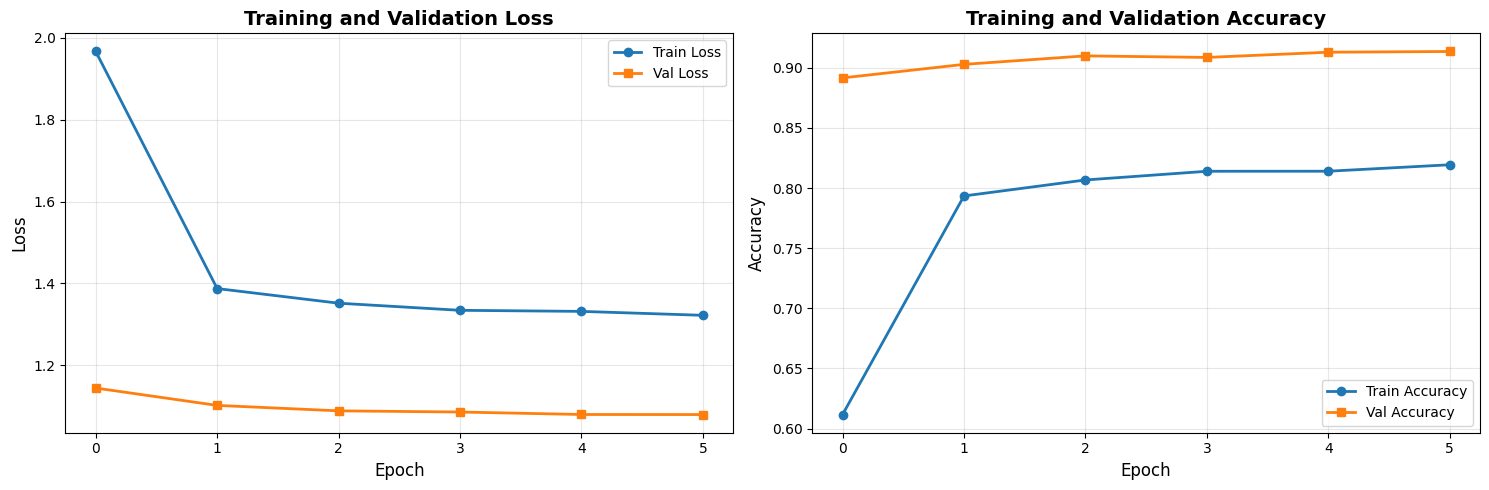


FINAL TRAINING METRICS
Final Train Loss: 1.3222
Final Train Acc: 0.8194
Final Train F1 (macro): 0.8179
Final Val Loss: 1.0797
Final Val Acc: 0.9136
Final Val F1 (macro): 0.9122


In [18]:
# --- Plot Training History ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*50)
print("FINAL TRAINING METRICS")
print("="*50)
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Train Acc: {history['train_acc'][-1]:.4f}")
print(f"Final Train F1 (macro): {history['train_f1'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Val Acc: {history['val_acc'][-1]:.4f}")
print(f"Final Val F1 (macro): {history['val_f1'][-1]:.4f}")
print("="*50)